In [122]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [123]:
df = (
    pd.read_csv('train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,

In [124]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

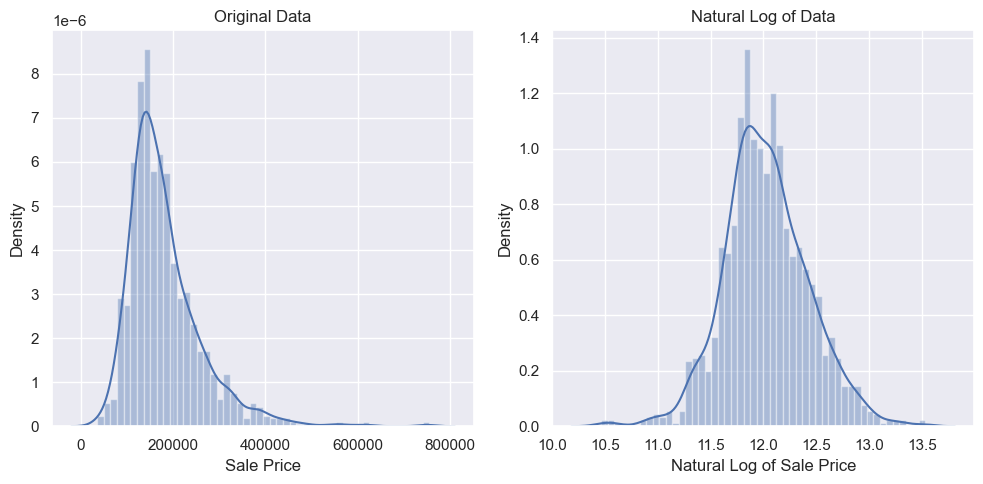

In [125]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

In [126]:
df.shape

(1460, 80)

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [127]:
### Можно воспользоваться такой компактной конструкцией

X = X.dropna(axis=1, thresh = 0.85*df.shape[0])

In [128]:
X.shape

(1460, 72)

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [109]:
unwanted_num_cols = ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']

### Выделим категориальные фичи

cat_cols = list(X.select_dtypes(include='object').columns)
cat_cols += unwanted_num_cols

X[cat_cols] = X[cat_cols].astype('object')

### Выделим вещественные фичи

num_cols = list(X.select_dtypes(exclude='object').columns)
num_cols = [ele for ele in num_cols if ele not in unwanted_num_cols]

### Заполним пропуски как и хотели!

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

In [110]:
X.isna().sum()

MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 72, dtype: int64

In [118]:
data_2 = pd.read_csv('hw19.csv', sep = ',')
data_2

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal


In [131]:
X = data_2

In [132]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [136]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Your code is here
cols_for_ohe = [col for col in cat_cols if X_train[col].nunique()<5]
cols_for_mte = [col for col in cat_cols if X_train[col].nunique()>=5]

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in num_cols]

In [138]:
t = [
    ('StandardScaler', StandardScaler(), numeric_cols_idx),
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers = t)

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [141]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here
pipe = Pipeline([('custom_transformer', col_transform),
                ('decision_tree', DecisionTreeRegressor())])

pipe.fit(X_train, y_train)

Качество на тесте: 0.737


In [143]:
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)

print(f'Качество на тесте: {test_error:.3f}')

Качество на тесте: 0.044


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [146]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here

pipe_rf = Pipeline([('custom_transformer', col_transform),
                   ('random_forest', RandomForestRegressor(random_state = 1))])

split = [(X_train.index.to_list(), X_test.index.to_list())]

search = GridSearchCV(pipe_rf, param_grid,
                     cv = split,
                     scoring = 'neg_mean_squared_error',
                     verbose = 10)
search.fit(X, log_target)
print(f'Best score is {search.best_score_:.5f}')
print(f'Best params are {search.best_params_}')

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.019 total time=   3.6s
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5
[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.019 total time=   3.3s
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10
[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=   3.0s
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2
[

Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here
lr_pipe = Pipeline([('custom_transformer', col_transform),
                   ('LR', LinearRegression())])
bagging = BaggingRegressor(lr_pipe,
                          n_estimators = 100,
                          random_state = 1)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=Pipeline(steps=[('custom_transformer',
                                            ColumnTransformer(transformers=[('StandardScaler',
                                                                             StandardScaler(),
                                                                             [0,
                                                                              2,
                                                                              14,
                                                                              15,
                                                                              23,
                                                                              31,
                                                                              33,
                                                                              34,
                                                                              35,
                                                                              40,
                                                                              41,
                                                                              42,
                                                                              43,
                                                                              44,
                                                                              45,
                                                                              46,
                                                                              47,
                                                                              48,
                                                                              49,
                                                                              51,
                                                                              53,
                                                                              57,
                                                                              58,
                                                                              62,
                                                                              63,
                                                                              64,
                                                                              65,
                                                                              66,
                                                                              67,
                                                                              68]),
                                                                            ('OneHotEncoder',
                                                                             OneHotEncoder(),
                                                                             [3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              8,
                                                                              24,
                                                                              27,
                                                                              28,
                                                                              29,
                                                                              37,
                                                                              38,
                                                                              50,
                                                                              56,
                                   

In [149]:
test_preds = bagging.predict(X_test)
print(f'Качество на тесте: {np.mean((test_preds - y_test)**2)}')

Качество на тесте: 0.017601407371302644


In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here
tree_pipe = Pipeline([('custom_transformer', col_transform),
                   ('decision_tree', DecisionTreeRegressor())])
bagging = BaggingRegressor(tree_pipe,
                          n_estimators = 100,
                          random_state = 1)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=Pipeline(steps=[('custom_transformer',
                                            ColumnTransformer(transformers=[('StandardScaler',
                                                                             StandardScaler(),
                                                                             [0,
                                                                              2,
                                                                              14,
                                                                              15,
                                                                              23,
                                                                              31,
                                                                              33,
                                                                              34,
                                                                              35,
                                                                              40,
                                                                              41,
                                                                              42,
                                                                              43,
                                                                              44,
                                                                              45,
                                                                              46,
                                                                              47,
                                                                              48,
                                                                              49,
                                                                              51,
                                                                              53,
                                                                              57,
                                                                              58,
                                                                              62,
                                                                              63,
                                                                              64,
                                                                              65,
                                                                              66,
                                                                              67,
                                                                              68]),
                                                                            ('OneHotEncoder',
                                                                             OneHotEncoder(),
                                                                             [3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              8,
                                                                              24,
                                                                              27,
                                                                              28,
                                                                              29,
                                                                              37,
                                                                              38,
                                                                              50,
                                                                              56,
                                   

In [152]:
test_preds = bagging.predict(X_test)
print(f'Качество на тесте: {np.mean((test_preds - y_test)**2)}')

Качество на тесте: 0.01815614421948241


In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here
forest_pipe = Pipeline([('custom_transformer', col_transform),
                   ('random_forest', RandomForestRegressor(random_state = 1))])
bagging = BaggingRegressor(forest_pipe,
                          n_estimators = 100,
                          random_state = 1)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=Pipeline(steps=[('custom_transformer',
                                            ColumnTransformer(transformers=[('StandardScaler',
                                                                             StandardScaler(),
                                                                             [0,
                                                                              2,
                                                                              14,
                                                                              15,
                                                                              23,
                                                                              31,
                                                                              33,
                                                                              34,
                                                                              35,
                                                                              40,
                                                                              41,
                                                                              42,
                                                                              43,
                                                                              44,
                                                                              45,
                                                                              46,
                                                                              47,
                                                                              48,
                                                                              49,
                                                                              51,
                                                                              53,
                                                                              57,
                                                                              58,
                                                                              62,
                                                                              63,
                                                                              64,
                                                                              65,
                                                                              66,
                                                                              67,
                                                                              68]),
                                                                            ('OneHotEncoder',
                                                                             OneHotEncoder(),
                                                                             [3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              8,
                                                                              24,
                                                                              27,
                                                                              28,
                                                                              29,
                                                                              37,
                                                                              38,
                                                                              50,
                                                                              56,
                                   

In [ ]:
test_preds = bagging.predict(X_test)
print(f'Качество на тесте: {round(np.mean((test_preds - y_test)**2),3)}')

Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [156]:
### Your code is here
def floor_occupation(x):
    if x['GrLivArea'] == 0:
        return 0
    return (x['1stFlrSF'] * 100) / x['GrLivArea']
    
X['floor_occupation'] = X.apply(
    lambda x: floor_occupation(x), axis = 1
)
X_train['floor_occupation'] = X_train.apply(
    lambda x: floor_occupation(x), axis = 1
)
X_test['floor_occupation'] = X_test.apply(
    lambda x: floor_occupation(x), axis = 1
)

In [157]:
def foundation_occupation(x):
    if x['TotalBsmtSF'] == 0:
        return 0
    return x['BsmtFinSF1'] * 100 / x['TotalBsmtSF']

X['foundation_occupation'] = X.apply(
    lambda x: foundation_occupation(x), axis = 1
)
X_train['foundation_occupation'] = X_train.apply(
    lambda x: foundation_occupation(x), axis = 1
)
X_test['foundation_occupation'] = X_test.apply(
    lambda x: foundation_occupation(x), axis = 1
)

In [158]:
def house_age(x):
    return x['YrSold'] - x['YearBuilt']

X['house_age'] = X.apply(
    lambda x: house_age(x), axis = 1
)
X_train['house_age'] = X_train.apply(
    lambda x: house_age(x), axis = 1
)
X_test['house_age'] = X_test.apply(
    lambda x: house_age(x), axis = 1
)

In [159]:
def general_square(x):
    return x['1stFlrSF'] + x['2ndFlrSF'] + x['TotalBsmtSF']

X['general_square'] = X.apply(
    lambda x: general_square(x), axis = 1
)
X_train['general_square'] = X_train.apply(
    lambda x: general_square(x), axis = 1
)
X_test['general_square'] = X_test.apply(
    lambda x: general_square(x), axis = 1
)

In [160]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here

pipe_rf = Pipeline([('custom_transformer', col_transform),
                   ('random_forest', RandomForestRegressor(random_state = 1))])

split = [(X_train.index.to_list(), X_test.index.to_list())]

search = GridSearchCV(pipe_rf, param_grid,
                     cv = split,
                     scoring = 'neg_mean_squared_error',
                     verbose = 10)
search.fit(X, log_target)
print(f'Best score is {search.best_score_:.5f}')
print(f'Best params are {search.best_params_}')

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-0.019 total time=   3.8s
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5
[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-0.019 total time=   3.3s
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10
[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-0.019 total time=   3.0s
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_forest__min_samples_split=2
[